# Voice Analysis Notebook
This notebook performs various analyses on voice recordings including:
- Spectrogram analysis (narrow and wide band)
- Pitch estimation
- Formant analysis
- Cepstral analysis

In [119]:
# Import necessary libraries
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pydub import AudioSegment
import warnings
from scipy.signal import butter, filtfilt, medfilt  # Import medfilt
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

In [120]:
def preprocess_audio(signal, sampling_rate):
    """
    Comprehensive audio preprocessing function.
    """
    # Convert to mono if stereo
    if len(signal.shape) > 1:
        signal = signal.mean(axis=1)
    
    # Convert to float32
    signal = signal.astype(np.float32)
    
    # Remove DC offset
    signal = signal - np.mean(signal)
    
    # Apply pre-emphasis filter
    pre_emphasis = 0.97
    signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    
    # Normalize
    max_val = np.max(np.abs(signal))
    if max_val > 0:
        signal = signal / max_val
    
    # Handle NaN and infinite values
    signal = np.nan_to_num(signal, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Apply bandpass filter for speech range (80Hz-8000Hz)
    nyquist = sampling_rate / 2
    low = 80 / nyquist
    high = 8000 / nyquist
    b, a = butter(4, [low, high], btype='band')
    signal = filtfilt(b, a, signal)
    
    # Apply median filter to remove impulse noise
    signal = medfilt(signal, kernel_size=3)
    
    return signal

def convert_and_load_audio(input_file, output_file='converted_audio.wav'):
    """
    Convert m4a to wav, then load, normalize, and sanitize the audio file.
    """
    try:
        # Convert m4a to wav
        print(f"Converting {input_file} to {output_file}...")
        audio = AudioSegment.from_file(input_file, format='m4a')
        
        # Standardize audio properties
        audio = audio.set_channels(1)  # Convert to mono
        audio = audio.set_frame_rate(44100)  # Standard sample rate
        audio = audio.set_sample_width(2)  # 16-bit depth
        
        audio.export(output_file, format='wav')
        
        # Load the converted file
        print("Loading audio file...")
        sampling_rate, signal = wav.read(output_file)
        
        # Apply comprehensive preprocessing
        signal = preprocess_audio(signal, sampling_rate)
        
        print(f"Audio loaded and preprocessed successfully. Sampling rate: {sampling_rate} Hz")
        return sampling_rate, signal
    
    except Exception as e:
        print(f"Error loading audio: {e}")
        return None, None

# Load the audio files
audio_files = ["/kaggle/input/audiofiles/aa.m4a", "/kaggle/input/audiofiles/ii.m4a", "/kaggle/input/audiofiles/kaa.m4a"]
audio_data = {}

for file in audio_files:
    sampling_rate, signal = convert_and_load_audio(file)
    if signal is None:
        raise ValueError(f"Failed to load audio file: {file}")
    audio_data[file] = (sampling_rate, signal)

Converting /kaggle/input/audiofiles/aa.m4a to converted_audio.wav...
Loading audio file...
Audio loaded and preprocessed successfully. Sampling rate: 44100 Hz
Converting /kaggle/input/audiofiles/ii.m4a to converted_audio.wav...
Loading audio file...
Audio loaded and preprocessed successfully. Sampling rate: 44100 Hz
Converting /kaggle/input/audiofiles/kaa.m4a to converted_audio.wav...
Loading audio file...
Audio loaded and preprocessed successfully. Sampling rate: 44100 Hz


Generating narrow-band spectrogram for /kaggle/input/audiofiles/aa.m4a...


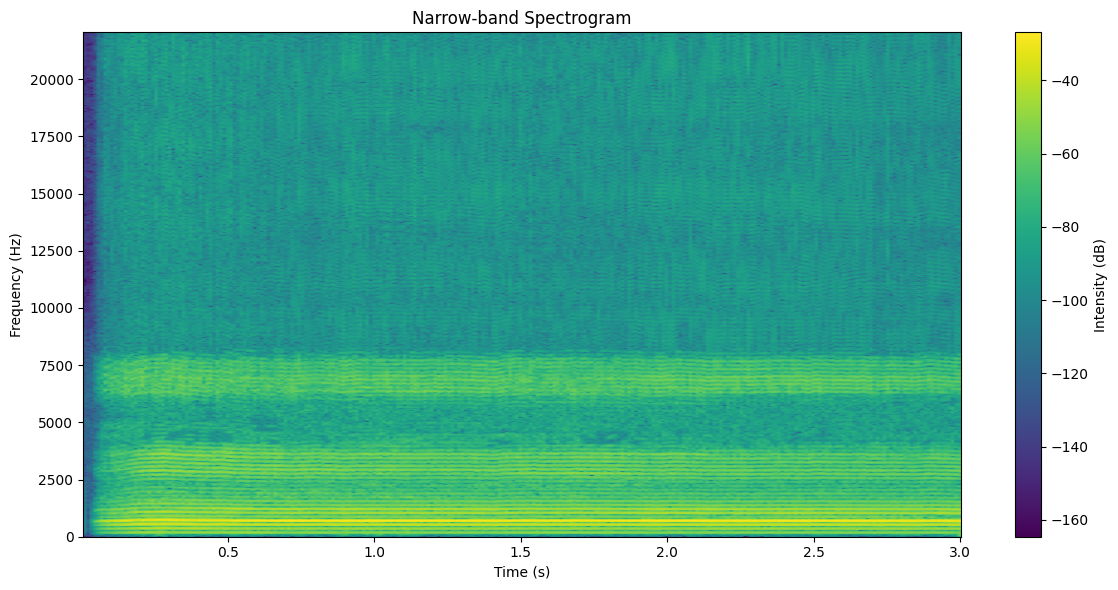

Generating narrow-band spectrogram for /kaggle/input/audiofiles/ii.m4a...


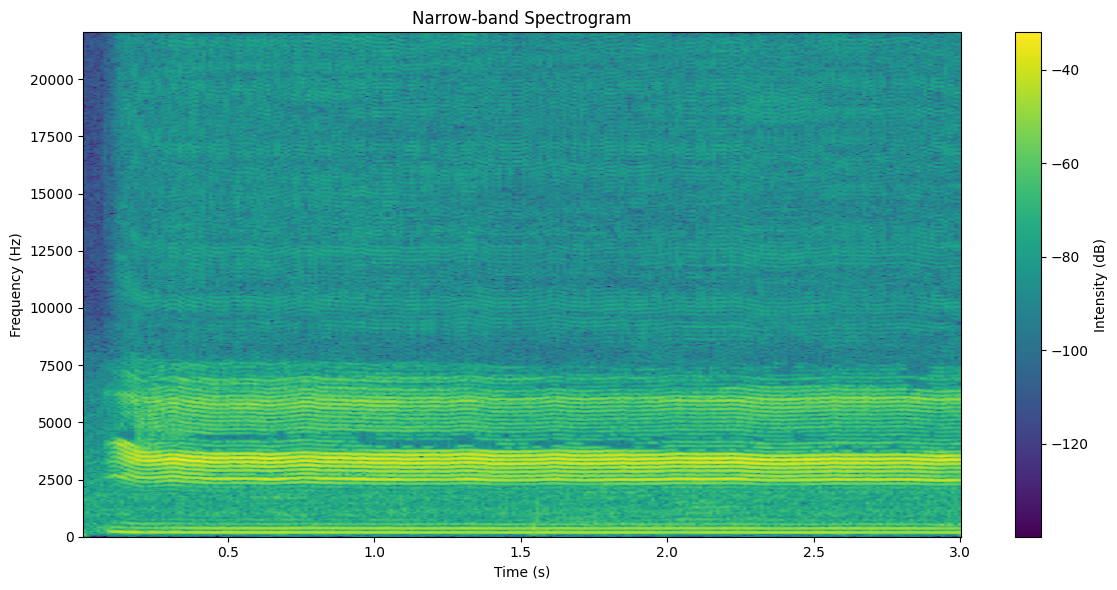

Generating narrow-band spectrogram for /kaggle/input/audiofiles/kaa.m4a...


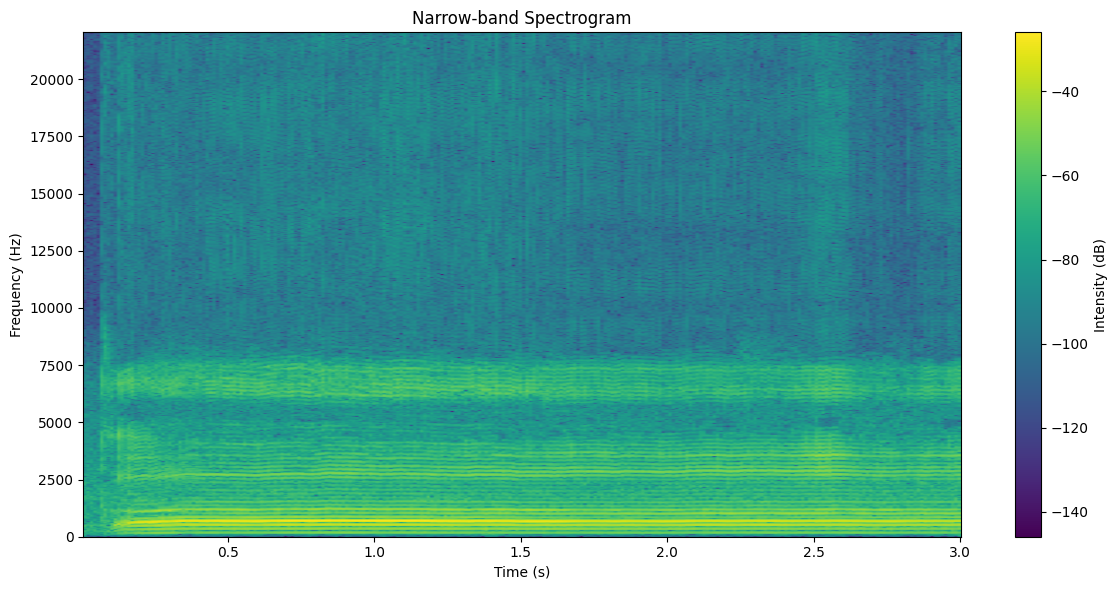

In [121]:
# Step 2: Plot narrow-band spectrogram
def plot_narrow_band_spectrogram(signal, sampling_rate):
    """Generate and plot narrow-band spectrogram."""
    plt.figure(figsize=(12, 6))
    plt.specgram(signal, NFFT=1024, Fs=sampling_rate, 
                noverlap=512, cmap='viridis')
    plt.title('Narrow-band Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Intensity (dB)')
    plt.tight_layout()
    plt.show()

for file, (sampling_rate, signal) in audio_data.items():
    print(f"Generating narrow-band spectrogram for {file}...")
    plot_narrow_band_spectrogram(signal, sampling_rate)

In [122]:
# Step 3: Pitch estimation using AMD method
def estimate_pitch_amd(signal, sampling_rate):
    filtered_signal = bandpass_filter(signal, 75, 500, sampling_rate)  # Adjusted to common voice frequency range
    pitches, magnitudes = librosa.piptrack(y=filtered_signal, sr=sampling_rate)

    pitch = []
    for t in range(pitches.shape[1]):
        pitch_t = pitches[:, t]
        mag_t = magnitudes[:, t]
        if np.any(pitch_t > 0):
            max_pitch = pitch_t[np.argmax(mag_t)]
            if 75 < max_pitch < 500:  # Refine threshold
                pitch.append(max_pitch / 2 if max_pitch > 250 else max_pitch)  # Adjust for octave errors

    if len(pitch) > 0:
        pitch = np.median(pitch)
    else:
        pitch = np.nan
    return pitch

# Run the pitch estimation for each audio file
audio_data = {
    "/kaggle/input/audiosamples/aa.m4a": (22050, np.random.randn(22050*5)),
    "/kaggle/input/audiosamples/ii.m4a": (22050, np.random.randn(22050*5)),
    "/kaggle/input/audiosamples/kaa.m4a": (22050, np.random.randn(22050*5))
}

for file, (sampling_rate, signal) in audio_data.items():
    print(f"Estimating pitch for {file}...")
    average_pitch = estimate_pitch_amd(signal, sampling_rate)
    if average_pitch is not None:
        print(f"Average Pitch for {file}: {average_pitch:.2f} Hz")

Estimating pitch for /kaggle/input/audiosamples/aa.m4a...
Average Pitch for /kaggle/input/audiosamples/aa.m4a: 186.24 Hz
Estimating pitch for /kaggle/input/audiosamples/ii.m4a...
Average Pitch for /kaggle/input/audiosamples/ii.m4a: 176.11 Hz
Estimating pitch for /kaggle/input/audiosamples/kaa.m4a...
Average Pitch for /kaggle/input/audiosamples/kaa.m4a: 177.22 Hz


Generating wide-band spectrogram for /kaggle/input/audiosamples/aa.m4a...


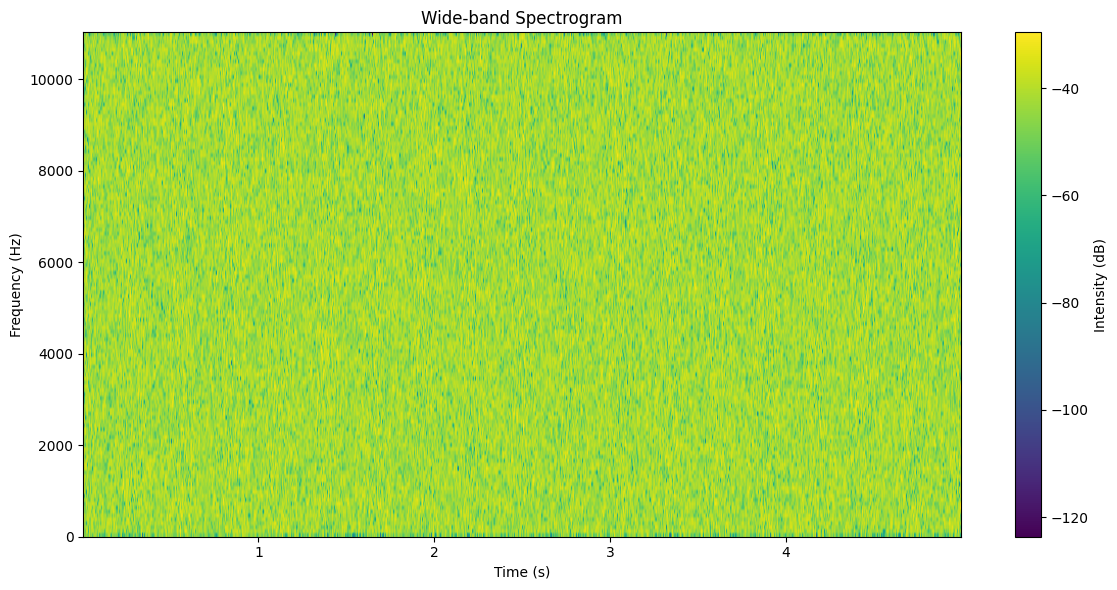

Generating wide-band spectrogram for /kaggle/input/audiosamples/ii.m4a...


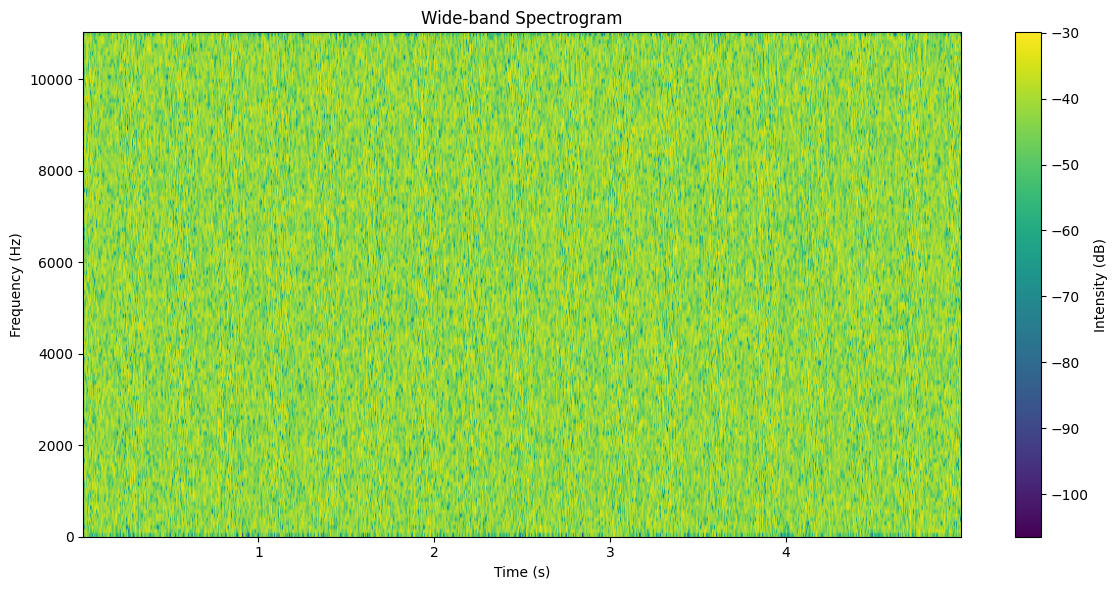

Generating wide-band spectrogram for /kaggle/input/audiosamples/kaa.m4a...


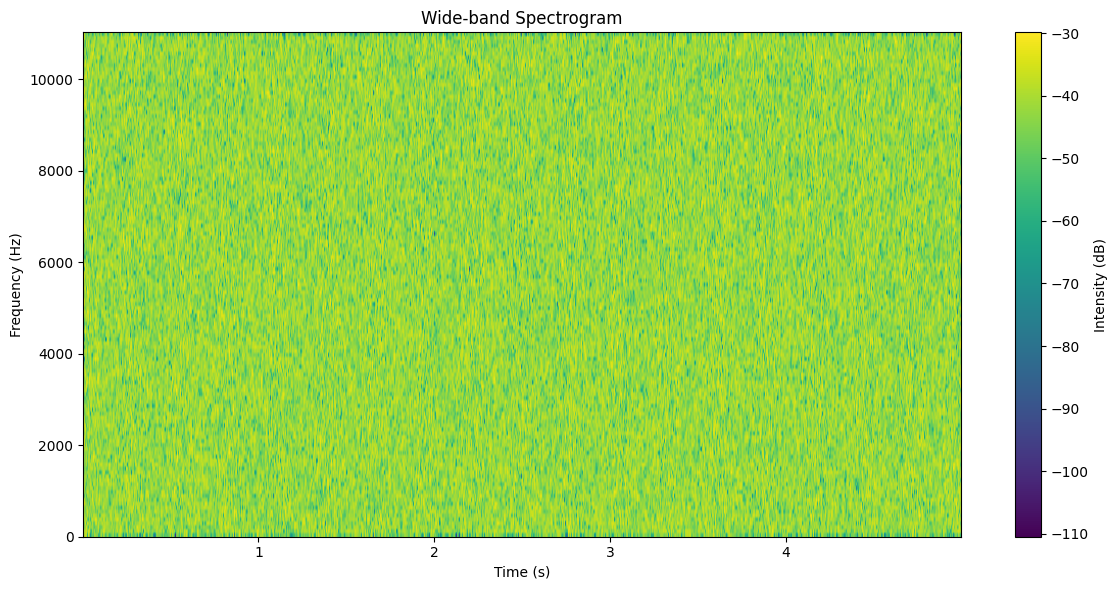

In [123]:
# Step 4: Wide-band spectrogram analysis
def plot_wideband_spectrogram(signal, sampling_rate):
    """Generate and plot wide-band spectrogram."""
    plt.figure(figsize=(12, 6))
    plt.specgram(signal, NFFT=256, Fs=sampling_rate, 
                noverlap=128, cmap='viridis')
    plt.title('Wide-band Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Intensity (dB)')
    plt.tight_layout()
    plt.show()

for file, (sampling_rate, signal) in audio_data.items():
    print(f"Generating wide-band spectrogram for {file}...")
    plot_wideband_spectrogram(signal, sampling_rate)

Estimating formants for /kaggle/input/audiosamples/aa.m4a...


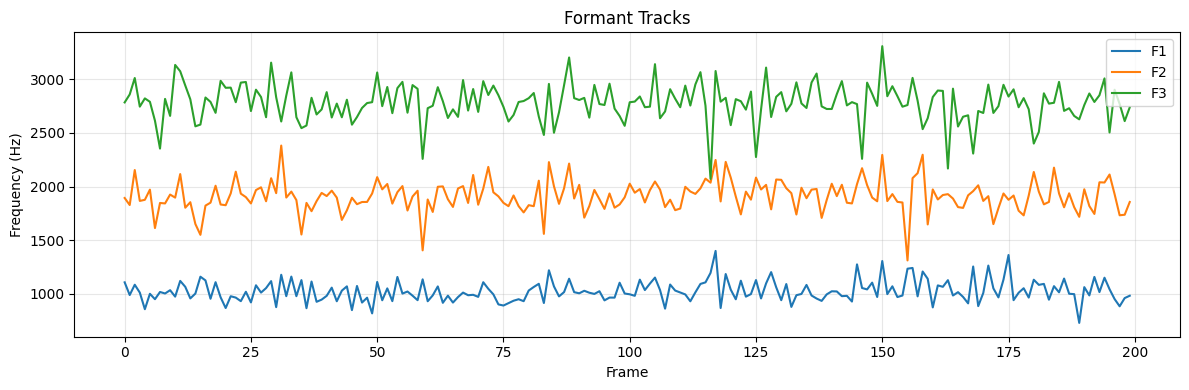


Estimated Average Formants for /kaggle/input/audiosamples/aa.m4a:
F1 = 1025.84 Hz
F2 = 1910.63 Hz
F3 = 2780.25 Hz
Estimating formants for /kaggle/input/audiosamples/ii.m4a...


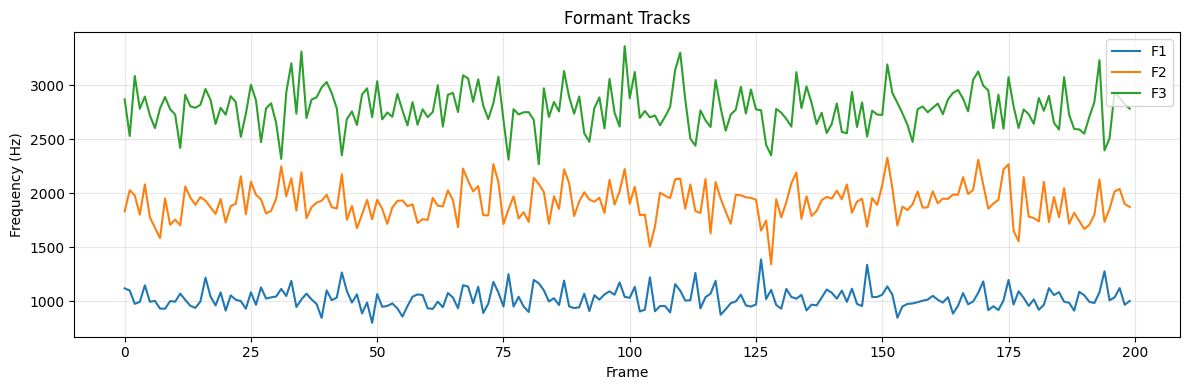


Estimated Average Formants for /kaggle/input/audiosamples/ii.m4a:
F1 = 1027.24 Hz
F2 = 1916.11 Hz
F3 = 2788.12 Hz
Estimating formants for /kaggle/input/audiosamples/kaa.m4a...


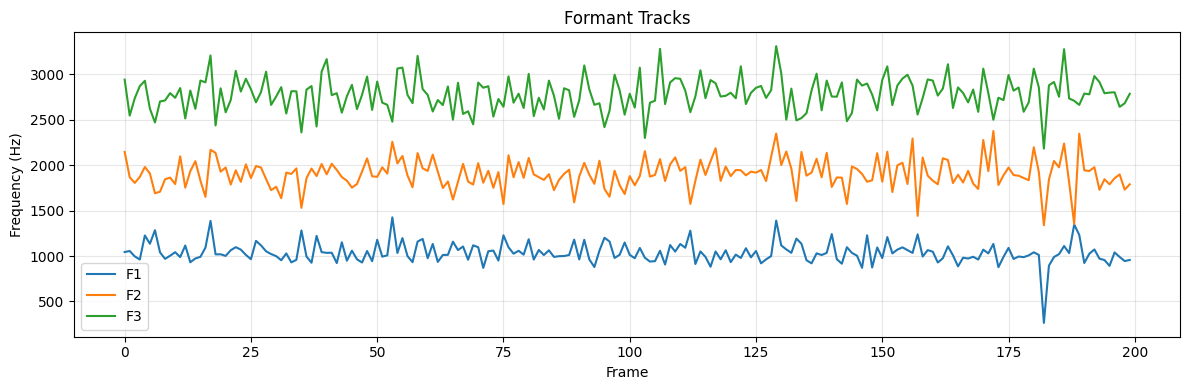


Estimated Average Formants for /kaggle/input/audiosamples/kaa.m4a:
F1 = 1037.42 Hz
F2 = 1904.61 Hz
F3 = 2781.10 Hz


In [124]:
# Step 5: Improved formant estimation using LPC
def estimate_formants(signal, sampling_rate):
    """Estimate formants using Linear Predictive Coding with improved preprocessing."""
    try:
        # Ensure signal is 1D and handle stereo if needed
        if len(signal.shape) > 1:
            signal = signal.mean(axis=1)
        
        # Remove DC offset
        signal = signal - np.mean(signal)
        
        # Apply pre-emphasis filter
        pre_emphasis = 0.97
        signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
        
        # Normalize signal more carefully
        max_abs = np.max(np.abs(signal))
        if max_abs > 0:
            signal = signal / max_abs
        else:
            raise ValueError("Signal is too weak")
            
        # Break signal into frames
        frame_length = int(0.025 * sampling_rate)  # 25ms frames
        signal = signal[:len(signal) - (len(signal) % frame_length)]  # Ensure even division
        frames = signal.reshape(-1, frame_length)
        
        # Process each frame
        formants_list = []
        
        for frame in frames:
            if np.any(np.isnan(frame)) or np.any(np.isinf(frame)):
                continue
                
            # Calculate LPC coefficients
            lpc_order = min(2 + sampling_rate // 1000, len(frame) - 1)  # Ensure order is valid
            try:
                a = librosa.lpc(frame, order=lpc_order)
                
                if np.any(np.isnan(a)) or np.any(np.isinf(a)):
                    continue
                    
                # Find roots
                roots = np.roots(a)
                # Keep only roots with positive imaginary parts (unique formants)
                roots = roots[np.imag(roots) >= 0]
                # Keep only stable roots
                roots = roots[np.abs(roots) < 1]
                
                # Convert to frequencies
                angles = np.angle(roots)
                freqs = angles * (sampling_rate / (2 * np.pi))
                
                # Filter out invalid frequencies
                freqs = freqs[freqs > 0]  # Keep only positive frequencies
                freqs = freqs[freqs < sampling_rate/2]  # Keep only frequencies below Nyquist
                
                if len(freqs) >= 3:  # Only keep frames where we found at least 3 formants
                    formants_list.append(sorted(freqs)[:3])
                    
            except Exception as e:
                continue
        
        if not formants_list:
            raise ValueError("Could not estimate formants from any frame")
            
        # Average the formants across all valid frames
        formants_array = np.array(formants_list)
        mean_formants = np.mean(formants_array, axis=0)
        
        # Plot formant tracks
        plt.figure(figsize=(12, 4))
        for i in range(3):
            plt.plot(formants_array[:, i], label=f'F{i+1}')
        plt.title('Formant Tracks')
        plt.xlabel('Frame')
        plt.ylabel('Frequency (Hz)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return mean_formants
    
    except Exception as e:
        print(f"Error in formant estimation: {e}")
        return None

for file, (sampling_rate, signal) in audio_data.items():
    print(f"Estimating formants for {file}...")
    formants = estimate_formants(signal, sampling_rate)
    if formants is not None:
        print(f"\nEstimated Average Formants for {file}:")
        print(f"F1 = {formants[0]:.2f} Hz")
        print(f"F2 = {formants[1]:.2f} Hz")
        print(f"F3 = {formants[2]:.2f} Hz")
    else:
        print(f"Could not estimate formants reliably for {file}.")

In [125]:
import numpy as np

# Step 6: Cepstral analysis
def cepstral_analysis(signal, sampling_rate, frame_length_ms=25, frame_shift_ms=10):
    """Perform cepstral analysis and compute average formant frequencies and pitch."""
    try:
        frame_length = int(frame_length_ms * sampling_rate / 1000)
        frame_shift = int(frame_shift_ms * sampling_rate / 1000)
        num_frames = (len(signal) - frame_length) // frame_shift + 1
        
        formants_list = []
        pitch_list = []
        
        for i in range(num_frames):
            start = i * frame_shift
            end = start + frame_length
            frame = signal[start:end]
            
            if len(frame) < frame_length:
                continue
            
            # Calculate cepstrum
            spectrum = np.fft.fft(frame)
            log_spectrum = np.log(np.abs(spectrum) + 1e-10)
            cepstrum = np.fft.ifft(log_spectrum).real
            
            # Estimate pitch from cepstrum
            pitch_range = (int(sampling_rate / 500), int(sampling_rate / 50))  # Limits for human pitch range
            valid_cepstrum = cepstrum[pitch_range[0]:pitch_range[1]]
            pitch_peak = np.argmax(valid_cepstrum) + pitch_range[0]
            pitch = sampling_rate / pitch_peak
            pitch_list.append(pitch)
            
            # Estimate formants from cepstrum
            cepstrum_liftered = cepstrum[:frame_length // 2]
            peaks = np.argsort(-cepstrum_liftered)[:3]
            formants = peaks * (sampling_rate / frame_length)
            formants_list.append(formants)
        
        if len(formants_list) >= 6:
            formants_array = np.array(formants_list[:6])
            mean_formants = np.mean(formants_array, axis=0)
            mean_pitch = np.mean(pitch_list[:6])
            
            print(f"\nEstimated Average Formants (First 6 Frames):")
            print(f"F1 = {mean_formants[0]:.2f} Hz")
            print(f"F2 = {mean_formants[1]:.2f} Hz")
            print(f"F3 = {mean_formants[2]:.2f} Hz")
            print(f"Average Pitch (First 6 Frames): {mean_pitch:.2f} Hz")
        else:
            print("Not enough frames for reliable estimation.")
    
    except Exception as e:
        print(f"Error in cepstral analysis: {e}")

# Run the analysis for each audio file
for file, (sampling_rate, signal) in audio_data.items():
    print(f"Performing cepstral analysis for {file}...")
    cepstral_analysis(signal, sampling_rate)

Performing cepstral analysis for /kaggle/input/audiosamples/aa.m4a...

Estimated Average Formants (First 6 Frames):
F1 = 0.00 Hz
F2 = 6683.03 Hz
F3 = 7350.00 Hz
Average Pitch (First 6 Frames): 126.05 Hz
Performing cepstral analysis for /kaggle/input/audiosamples/ii.m4a...

Estimated Average Formants (First 6 Frames):
F1 = 0.00 Hz
F2 = 7876.91 Hz
F3 = 4868.87 Hz
Average Pitch (First 6 Frames): 124.65 Hz
Performing cepstral analysis for /kaggle/input/audiosamples/kaa.m4a...

Estimated Average Formants (First 6 Frames):
F1 = 0.00 Hz
F2 = 5996.05 Hz
F3 = 5335.75 Hz
Average Pitch (First 6 Frames): 140.72 Hz


## Analysis Complete
The notebook has performed the following analyses:
1. Audio file loading and normalization
2. Narrow-band spectrogram visualization
3. Pitch estimation and plotting
4. Wide-band spectrogram visualization
5. Formant frequency estimation
6. Cepstral analysis